In [45]:
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import Subset
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from PIL import Image as PILImage
from IPython.display import Image
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
"""
Enables GPU for faster training
"""

seed = 0
np.random.seed(seed)
torch.manual_seed(seed)

if torch.cuda.is_available():
  torch.backends.cudnn.deterministic = True
  torch.cuda.manual_seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
"""
Defines a custom dataset in order to implement pytorch's built in model capabilities
"""

class RoverDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = pd.read_csv(csv_file, sep=";")
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.data["Path"][idx]
        index = img_name.find("robocam")
        #local_path = self.root_dir + img_name[index:]
        local_path = "/home/exouser/IMG/" + img_name[index:]
        #local_path = "/home/exouser/AblationIMG/" + img_name[index:]
        
        try:
            image = Image.open(local_path)
        except FileNotFoundError:
            return self.__getitem__((idx + 1) % len(self))

        steering_angle = float(self.data["SteerAngle"][idx])
        throttle = float(self.data["Throttle"][idx])
        
        steering_angle_tensor = torch.tensor(steering_angle, dtype=torch.float32)
        throttle_tensor = torch.tensor(throttle, dtype=torch.float32)
        
        if self.transform:
            image = self.transform(image)

        return {'image': image, 'SteerAngle': steering_angle, 'Throttle': throttle}
        

In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),          
    transforms.Normalize(            
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [5]:
def run_model(sample_dataset, model, optimizer):    

    train_size = int(0.9 * len(sample_dataset))
    test_size = len(sample_dataset) - train_size
    train_set, test_set = random_split(sample_dataset, [train_size, test_size])
    
    train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=32, shuffle=True)

    model.fc = nn.Linear(model.fc.in_features, 2)

    criterion = nn.MSELoss()

    model.to(device)

    train_losses = []
    test_losses = []

    for param in model.parameters():
        param.to(device)

    num_epochs = 30
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for batch in train_loader:
            images, targets = batch['image'].to(device), torch.stack((batch['SteerAngle'], batch['Throttle']), dim=1).to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, targets.float())
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for batch in test_loader:
                images, targets = batch['image'].to(device), torch.stack((batch['SteerAngle'], batch['Throttle']), dim=1).to(device)
                outputs = model(images)
                loss = criterion(outputs, targets.float())
                test_loss += loss.item() * images.size(0)
        test_loss /= len(test_loader.dataset)
        test_losses.append(test_loss)

    graph_loss(train_losses, test_losses, num_epochs)

In [6]:
def graph_loss(train_losses, test_losses, num_epochs):
    axis = list(range(1,num_epochs + 1))
    fig, ax = plt.subplots()

    a, = ax.plot(axis, train_losses)
    b, = ax.plot(axis, test_losses)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.legend((a, b), ('Train Loss', 'Test Loss'), loc='upper right', shadow=True)

    plt.show()

In [7]:
full_dataset = RoverDataset(csv_file="/home/exouser/robot_log.csv", root_dir="/home/exouser/IMG", transform=transform)

In [9]:
#Examine image size

/home/exouser/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


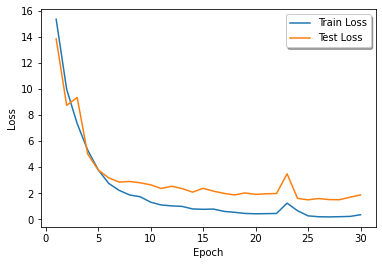

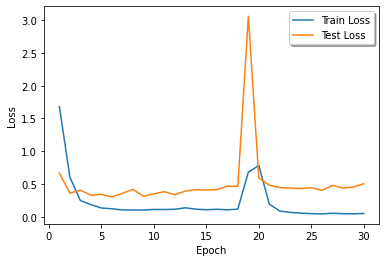

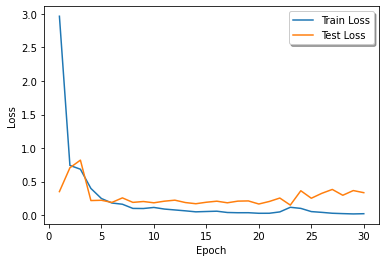

In [10]:
sample_19000 = Subset(full_dataset, range(19000))
sample_8000 = Subset(full_dataset, range(8000))
sample_2000 = Subset(full_dataset, range(2000))

model = models.resnet18(pretrained=True)
optimizer = optim.Adam(model.parameters(), lr=0.001)

run_model(sample_19000, model, optimizer)
run_model(sample_8000, model, optimizer)
run_model(sample_2000, model, optimizer)

In [9]:
sample_19000 = Subset(full_dataset, range(19000))
sample_8000 = Subset(full_dataset, range(8000))
sample_2000 = Subset(full_dataset, range(2000))
model = models.resnet18(pretrained=True)
optimizer = optim.Adam(model.parameters(), lr=0.001)

/home/exouser/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
#Examine model size

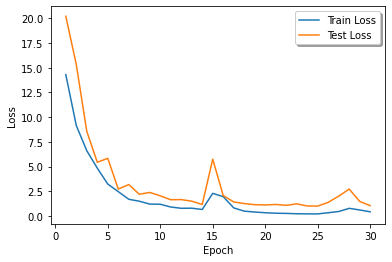

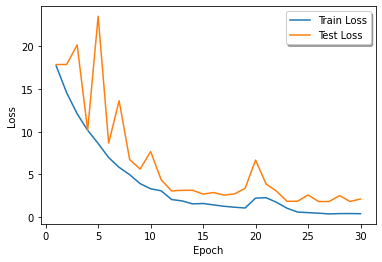

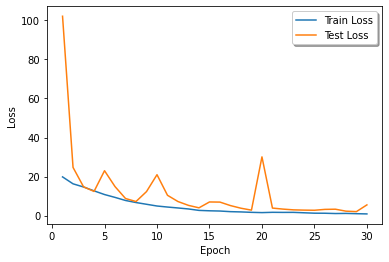

In [12]:
sample = Subset(full_dataset, range(8000))
model_resnet18 = models.resnet18(pretrained=True)
model_resnet50 = models.resnet50(pretrained=True)
model_resnet101 = models.resnet101(pretrained=True)
optimizerA = optim.Adam(model_resnet18.parameters(), lr=0.001)
optimizerB = optim.Adam(model_resnet50.parameters(), lr=0.001)
optimizerC = optim.Adam(model_resnet101.parameters(), lr=0.001)

run_model(sample, model_resnet18, optimizerA)
run_model(sample, model_resnet50, optimizerB)
run_model(sample, model_resnet101, optimizerC)

In [ ]:
#Examine optimizers

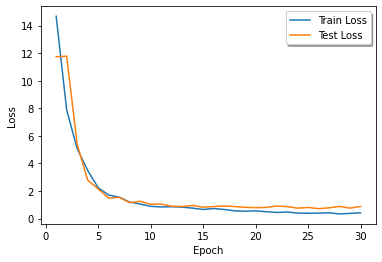

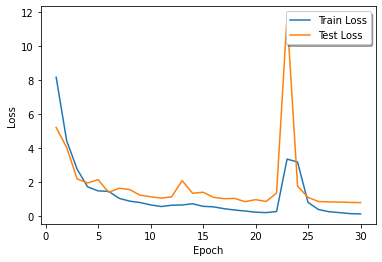

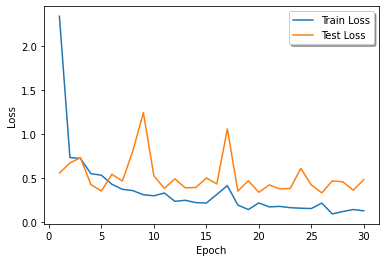

In [10]:
sample = sample_8000
optimizer_SGD = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer_Adam = optim.Adam(model.parameters(), lr=0.001)
optimizer_RMSprop = optim.RMSprop(model.parameters(), lr=0.001)

run_model(sample, model, optimizer_SGD)
run_model(sample, model, optimizer_Adam)
run_model(sample, model, optimizer_RMSprop)


In [ ]:
#Ablation study

In [9]:
ablation_dataset = RoverDataset(csv_file="/home/exouser/AblationData.csv", root_dir="/home/exouser/AblationIMG", transform=transform)

In [12]:
ablation_sample = Subset(ablation_dataset, range(5000))

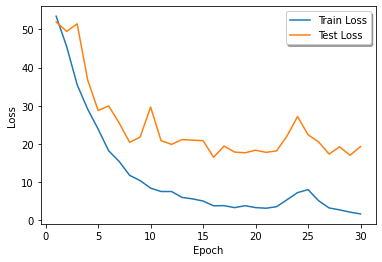

In [13]:
model = models.resnet18(pretrained=True)
optimizer = optim.SGF(model.parameters(), lr=0.001)
run_model(ablation_sample, model, optimizer)

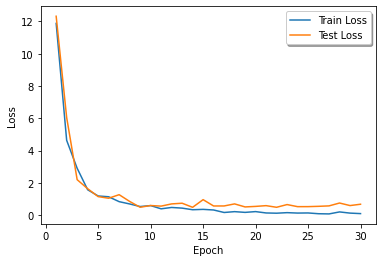

In [9]:
#Combination Model
model_resnet101 = models.resnet101(pretrained=True)
optimizer_SGD = optim.SGD(model_resnet101.parameters(), lr=0.001, momentum=0.9)
sample_2000 = Subset(full_dataset, range(2000))
run_model(sample_2000, model_resnet101, optimizer_SGD) 

In [46]:
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = PILImage.open(image_path)
    image = transform(image).unsqueeze(0) 
    return image

def predict_image(image, model):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    image = image.to(device)
    model.eval()  # Set model to evaluation mode

    with torch.no_grad():
        output = model(image)

    predicted_steer_angle, predicted_throttle = output.squeeze().tolist()
    
    
    print("Predicted Steering Angle:", predicted_steer_angle)
    print("Predicted Throttle:", predicted_throttle)


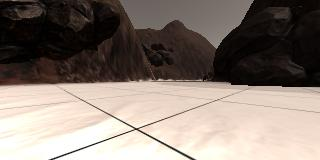

In [53]:
image_path = "RoverImages/robocam_2024_03_21_21_27_23_078.jpg"
Image(filename=image_path)

In [55]:
image = preprocess_image(image_path)
predict_image(image, model_resnet101)

Predicted Steering Angle: -3.7354683876037598
Predicted Throttle: 1.1449931859970093


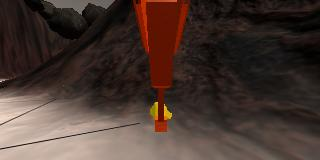

In [56]:
image_path = "RoverImages/robocam_2024_03_21_21_28_01_244.jpg"
Image(filename=image_path)

In [57]:
image = preprocess_image(image_path)
predict_image(image, model_resnet101)

Predicted Steering Angle: -3.5880813598632812
Predicted Throttle: -0.6073366403579712


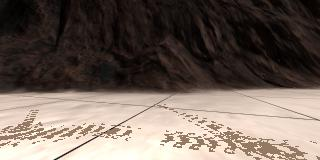

In [58]:
image_path = "RoverImages/robocam_2024_03_21_21_28_13_600.jpg"
Image(filename=image_path)

In [59]:
image = preprocess_image(image_path)
predict_image(image, model_resnet101)

Predicted Steering Angle: -8.698272705078125
Predicted Throttle: -0.19499729573726654


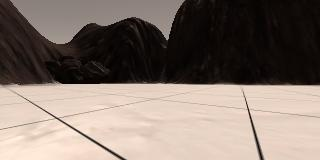

In [62]:
image_path = "RoverImages/robocam_2024_03_21_21_28_32_373.jpg"
Image(filename=image_path)

In [63]:
image = preprocess_image(image_path)
predict_image(image, model_resnet101)

Predicted Steering Angle: 4.364030361175537
Predicted Throttle: 0.9749716520309448
